# 08.01 Analysis of Results

## Imports and Setup

In [1]:
import pathlib
from datetime import datetime
import math
import sys

import pandas as pd
import numpy as np

import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.dates import DateFormatter
import matplotlib.dates as mdates
import seaborn as sns

from sklearn.metrics import mean_absolute_error
from sklearn.pipeline import Pipeline

sys.path.append("..")
from src.utils.utils import (bound_precision,
                             AnnualTimeSeriesSplit,
                             run_cross_val,
                             RollingAnnualTimeSeriesSplit)
from src.visualization.visualize import (plot_prediction,
                                         plot_joint_plot,
                                         residual_plots,
                                         print_residual_stats,
                                         resids_vs_preds_plot,
                                         seasonal_plot)
from src.features.features import CyclicalToCycle

%matplotlib inline



pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

# Data
PROJECT_DIR = pathlib.Path.cwd().parent.resolve()
CLEAN_DATA_DIR = PROJECT_DIR / 'data' / '05-clean'
MODELS_DIR = PROJECT_DIR / 'data' / 'models'
RESULTS_PATH = PROJECT_DIR / 'data' /'results' / 'results.csv'

In [2]:
results = pd.read_csv(RESULTS_PATH, index_col=0, header=[0,1])
# Standardize the multi index
results = results.rename(columns={'bound_precision':'bound'}, level=1)
results.head(12)

Baseline            Prophet       Prophet + XGBoost       Prophet + SVR       Prophet + ExtraTreesRegressor       Prophet + KNeighborsRegressor          SARIMAX I         SARIMAX II        SARIMAX III         SARIMAX IV       SARIMAX IV + XGBoost       SARIMAX IV + SVR       SARIMAX IV + ExtraTreesRegressor       SARIMAX IV + KNeighborsRegressor         Averaging      
              mae bound          mae bound               mae bound           mae bound                           mae bound                           mae bound          mae bound          mae bound          mae bound          mae bound                  mae bound              mae bound                              mae bound                              mae bound         mae bound
1999   785.341009   0.6   720.218501   0.8        564.413176   0.8    560.362095   0.8                    569.261791   0.8                    584.775158   0.8  1112.077920   0.4  1236.283269   0.2  1166.446318   0.2  1390.099386   0.8          1257.158536   0.4      1174.575133   0.8                      1211.845897   0.6                      1224.648012   0.6  628.172074   0.8
2000   841.496643   0.8   538.393316   0.8        388.030452   0.8    362.055640   1.0                    432.848825   0.8                    424.615675   1.0   668.878294   0.8   603.228495   0.8   769.569664   0.8  1023.114768   0.6          1021.160117   1.0      1116.721068   0.8                      1103.149177   0.6                      1105.228994   0.8  577.532860   1.0
2001   971.010973   0.6   730.275530   1.0        521.176514   1.0    454.831895   0.8                    469.712880   1.0                    526.795331   1.0   987.696046   1.0  1080.461134   0.8  1458.076339   0.8  1001.382716   0.8           837.599117   0.6       805.532774   0.8                       829.989353   0.8                       819.764093   0.6  550.058093   0.8
2002  1120.417756   0.4   712.523997   0.4        509.309746   0.6    481.726185   0.6                    488.165615   0.4                    524.243588   0.4   823.644842   0.4   867.031741   0.4   942.186996   0.4  1233.339897   0.4          1043.418945   0.6      1014.985346   0.6                      1009.261307   0.4                      1036.135160   0.6  651.339700   0.6
2003  1576.417824   0.6   938.619116   0.6        837.172955   0.4    795.189746   0.6                    824.453637   0.4                    813.178224   0.6   867.642272   0.2   919.126232   0.2   963.815242   0.2   661.814829   0.4           547.842212   0.4       469.102069   0.4                       583.426383   0.4                       583.795998   0.4  458.802039   0.4
2004  1447.394438   0.6   605.586615   0.8        635.993295   0.8    611.734944   0.8                    649.982311   0.8                    621.805963   0.8   712.122756   0.6   737.092050   0.6  3413.988221   0.6   520.855617   0.8           555.814645   0.8       557.818176   0.8                       535.606550   0.8                       557.303043   0.6  572.905363   0.8
2005  1137.307718   0.2   982.040388   0.2        768.483651   0.2    751.081354   0.2                    723.383167   0.2                    737.333514   0.2  1080.163584   0.4   880.112051   0.2  1318.535450   0.2   998.366150   0.2           744.628009   0.4       715.551302   0.2                       731.671904   0.4                       731.370754   0.2  725.746761   0.2
2006  1502.960994   0.8  1038.864989   1.0        894.626531   1.0    934.563744   1.0                    942.230578   1.0                    957.100781   1.0   872.469006   1.0   963.159329   1.0   996.059642   1.0   546.189699   1.0           418.945219   1.0       427.989603   1.0                       436.960306   1.0                       463.076545   1.0  536.727330   1.0
2007  2523.435378   0.6   660.926417   0.8        518.663409   0.8    519.714902   0.8                    504.265912   0.8                    563.747546   0.8  1086.775431   0.6   972.317453   0.6  1

In [3]:
results.describe()

Baseline                 Prophet            Prophet + XGBoost            Prophet + SVR            Prophet + ExtraTreesRegressor            Prophet + KNeighborsRegressor               SARIMAX I              SARIMAX II             SARIMAX III              SARIMAX IV            SARIMAX IV + XGBoost          SARIMAX IV + SVR            SARIMAX IV + ExtraTreesRegressor            SARIMAX IV + KNeighborsRegressor              Averaging           
               mae      bound          mae      bound               mae      bound           mae      bound                           mae      bound                           mae      bound          mae      bound          mae      bound          mae      bound          mae      bound                  mae    bound              mae      bound                              mae      bound                              mae      bound         mae      bound
count    10.000000  10.000000    10.000000  10.000000         10.000000  10.000000     10.000000  10.000000                     10.000000  10.000000                     10.000000  10.000000    10.000000  10.000000    10.000000  10.000000    10.000000  10.000000    10.000000  10.000000            10.000000  10.0000        10.000000  10.000000                        10.000000  10.000000                        10.000000  10.000000   10.000000  10.000000
mean   1433.909276   0.600000   753.349170   0.700000        611.526653   0.700000    592.852404   0.720000                    611.372148   0.680000                    624.397987   0.720000   916.881330   0.580000   926.961930   0.520000  1376.773783   0.520000   878.090124   0.640000           741.612133   0.6600       719.619771   0.680000                       754.951532   0.620000                       761.721192   0.620000  556.265443   0.700000
std     613.120022   0.188562   173.115746   0.253859        167.892818   0.253859    180.294478   0.234758                    169.858090   0.269979                    163.899903   0.269979   155.206047   0.274064   175.227155   0.285968   759.673174   0.285968   297.801585   0.245855           287.428371   0.2319       293.435568   0.234758                       271.310629   0.198886                       272.110806   0.220101  100.130769   0.253859
min     785.341009   0.200000   538.393316   0.200000        388.030452   0.200000    362.055640   0.200000                    432.848825   0.200000                    424.615675   0.200000   668.878294   0.200000   603.228495   0.200000   769.569664   0.200000   520.855617   0.200000           418.945219   0.4000       414.173927   0.200000                       436.960306   0.400000                       463.076545   0.200000  380.125604   0.200000
25%    1008.362669   0.600000   619.763726   0.600000        511.648162   0.600000    463.379201   0.600000                    492.190689   0.450000                    524.881524   0.600000   834.644199   0.400000   870.301819   0.250000   971.876342   0.250000   631.762019   0.450000           526.824746   0.4500       476.763629   0.600000                       547.561508   0.450000                       558.808189   0.600000  495.115290   0.600000
50%    1292.351078   0.600000   716.371249   0.800000        542.794845   0.800000    540.038499   0.800000                    539.339277   0.800000                    574.261352   0.800000   914.906076   0.500000   941.142781   0.500000  1147.415358   0.500000   891.179959   0.700000           650.221327   0.6000       636.684739   0.800000                       658.828093   0.600000                       657.583376   0.600000  561.481728   0.800000
75%    1558.053616   0.750000   886.533219   0.800000        735.361062   0.800000    716.244751   0.800000                    705.032953   0.800000                    708.451626   0.950000  1057.046699   0.750000  1001.185023   0.750000  1423.191116   0.750000  1017.681755   0.800000           975.269867   0.8000       962.622203   0.800000                       964.

In [4]:
# Drop the additional and lower performing SARIMAX Models to make plots more readable
results = results.drop(['SARIMAX II', 'SARIMAX III'], axis=1, level=0)
results.head(12)

Baseline            Prophet       Prophet + XGBoost       Prophet + SVR       Prophet + ExtraTreesRegressor       Prophet + KNeighborsRegressor          SARIMAX I         SARIMAX IV       SARIMAX IV + XGBoost       SARIMAX IV + SVR       SARIMAX IV + ExtraTreesRegressor       SARIMAX IV + KNeighborsRegressor         Averaging      
              mae bound          mae bound               mae bound           mae bound                           mae bound                           mae bound          mae bound          mae bound                  mae bound              mae bound                              mae bound                              mae bound         mae bound
1999   785.341009   0.6   720.218501   0.8        564.413176   0.8    560.362095   0.8                    569.261791   0.8                    584.775158   0.8  1112.077920   0.4  1390.099386   0.8          1257.158536   0.4      1174.575133   0.8                      1211.845897   0.6                      1224.648012   0.6  628.172074   0.8
2000   841.496643   0.8   538.393316   0.8        388.030452   0.8    362.055640   1.0                    432.848825   0.8                    424.615675   1.0   668.878294   0.8  1023.114768   0.6          1021.160117   1.0      1116.721068   0.8                      1103.149177   0.6                      1105.228994   0.8  577.532860   1.0
2001   971.010973   0.6   730.275530   1.0        521.176514   1.0    454.831895   0.8                    469.712880   1.0                    526.795331   1.0   987.696046   1.0  1001.382716   0.8           837.599117   0.6       805.532774   0.8                       829.989353   0.8                       819.764093   0.6  550.058093   0.8
2002  1120.417756   0.4   712.523997   0.4        509.309746   0.6    481.726185   0.6                    488.165615   0.4                    524.243588   0.4   823.644842   0.4  1233.339897   0.4          1043.418945   0.6      1014.985346   0.6                      1009.261307   0.4                      1036.135160   0.6  651.339700   0.6
2003  1576.417824   0.6   938.619116   0.6        837.172955   0.4    795.189746   0.6                    824.453637   0.4                    813.178224   0.6   867.642272   0.2   661.814829   0.4           547.842212   0.4       469.102069   0.4                       583.426383   0.4                       583.795998   0.4  458.802039   0.4
2004  1447.394438   0.6   605.586615   0.8        635.993295   0.8    611.734944   0.8                    649.982311   0.8                    621.805963   0.8   712.122756   0.6   520.855617   0.8           555.814645   0.8       557.818176   0.8                       535.606550   0.8                       557.303043   0.6  572.905363   0.8
2005  1137.307718   0.2   982.040388   0.2        768.483651   0.2    751.081354   0.2                    723.383167   0.2                    737.333514   0.2  1080.163584   0.4   998.366150   0.2           744.628009   0.4       715.551302   0.2                       731.671904   0.4                       731.370754   0.2  725.746761   0.2
2006  1502.960994   0.8  1038.864989   1.0        894.626531   1.0    934.563744   1.0                    942.230578   1.0                    957.100781   1.0   872.469006   1.0   546.189699   1.0           418.945219   1.0       427.989603   1.0                       436.960306   1.0                       463.076545   1.0  536.727330   1.0
2007  2523.435378   0.6   660.926417   0.8        518.663409   0.8    519.714902   0.8                    504.265912   0.8                    563.747546   0.8  1086.775431   0.6   783.993768   0.8           519.818923   0.8       499.748310   0.8                       585.984283   0.6                       563.323627   0.8  481.244610   0.8
2008  2433.310031   0.8   606.042829   0.6        477.396795   0.6    457.263540   0.6                    509.416763   0.6                    490.384089   0.6   957.343146   0.4   621.744415   0.6           469.735605   0.6       414.17

In [5]:
results.iloc[:, [4,5,14,15]].head(15)

Prophet + XGBoost         SARIMAX IV      
                   mae bound          mae bound
1999        564.413176   0.8  1390.099386   0.8
2000        388.030452   0.8  1023.114768   0.6
2001        521.176514   1.0  1001.382716   0.8
2002        509.309746   0.6  1233.339897   0.4
2003        837.172955   0.4   661.814829   0.4
2004        635.993295   0.8   520.855617   0.8
2005        768.483651   0.2   998.366150   0.2
2006        894.626531   1.0   546.189699   1.0
2007        518.663409   0.8   783.993768   0.8
2008        477.396795   0.6   621.744415   0.6

In [6]:
results.describe()

Baseline                 Prophet            Prophet + XGBoost            Prophet + SVR            Prophet + ExtraTreesRegressor            Prophet + KNeighborsRegressor               SARIMAX I              SARIMAX IV            SARIMAX IV + XGBoost          SARIMAX IV + SVR            SARIMAX IV + ExtraTreesRegressor            SARIMAX IV + KNeighborsRegressor              Averaging           
               mae      bound          mae      bound               mae      bound           mae      bound                           mae      bound                           mae      bound          mae      bound          mae      bound                  mae    bound              mae      bound                              mae      bound                              mae      bound         mae      bound
count    10.000000  10.000000    10.000000  10.000000         10.000000  10.000000     10.000000  10.000000                     10.000000  10.000000                     10.000000  10.000000    10.000000  10.000000    10.000000  10.000000            10.000000  10.0000        10.000000  10.000000                        10.000000  10.000000                        10.000000  10.000000   10.000000  10.000000
mean   1433.909276   0.600000   753.349170   0.700000        611.526653   0.700000    592.852404   0.720000                    611.372148   0.680000                    624.397987   0.720000   916.881330   0.580000   878.090124   0.640000           741.612133   0.6600       719.619771   0.680000                       754.951532   0.620000                       761.721192   0.620000  556.265443   0.700000
std     613.120022   0.188562   173.115746   0.253859        167.892818   0.253859    180.294478   0.234758                    169.858090   0.269979                    163.899903   0.269979   155.206047   0.274064   297.801585   0.245855           287.428371   0.2319       293.435568   0.234758                       271.310629   0.198886                       272.110806   0.220101  100.130769   0.253859
min     785.341009   0.200000   538.393316   0.200000        388.030452   0.200000    362.055640   0.200000                    432.848825   0.200000                    424.615675   0.200000   668.878294   0.200000   520.855617   0.200000           418.945219   0.4000       414.173927   0.200000                       436.960306   0.400000                       463.076545   0.200000  380.125604   0.200000
25%    1008.362669   0.600000   619.763726   0.600000        511.648162   0.600000    463.379201   0.600000                    492.190689   0.450000                    524.881524   0.600000   834.644199   0.400000   631.762019   0.450000           526.824746   0.4500       476.763629   0.600000                       547.561508   0.450000                       558.808189   0.600000  495.115290   0.600000
50%    1292.351078   0.600000   716.371249   0.800000        542.794845   0.800000    540.038499   0.800000                    539.339277   0.800000                    574.261352   0.800000   914.906076   0.500000   891.179959   0.700000           650.221327   0.6000       636.684739   0.800000                       658.828093   0.600000                       657.583376   0.600000  561.481728   0.800000
75%    1558.053616   0.750000   886.533219   0.800000        735.361062   0.800000    716.244751   0.800000                    705.032953   0.800000                    708.451626   0.950000  1057.046699   0.750000  1017.681755   0.800000           975.269867   0.8000       962.622203   0.800000                       964.443319   0.750000                       982.042393   0.750000  615.512271   0.800000
max    2523.435378   0.800000  1038.864989   1.000000        894.626531   1.000000    934.563744   1.000000                    942.230578   1.000000                    957.100781   1.000000  1112.077920   1.000000  1390.099386   1.000000          1257.158536   1.0000      1174.575133   1.000000                      1211.845897   1.000000        

In [7]:
results.columns = [' '.join(col).strip() for col in results.columns.values]

In [8]:
mae_results = results[[col for col in results.columns if 'mae' in col]]
#mae_results.reset_index(drop=True, inplace=True)
mae_results

,Baseline mae,Prophet mae,Prophet + XGBoost mae,Prophet + SVR mae,Prophet + ExtraTreesRegressor mae,Prophet + KNeighborsRegressor mae,SARIMAX I mae,SARIMAX IV mae,SARIMAX IV + XGBoost mae,SARIMAX IV + SVR mae,SARIMAX IV + ExtraTreesRegressor mae,SARIMAX IV + KNeighborsRegressor mae,Averaging mae
1999,785.341009,720.218501,564.413176,560.362095,569.261791,584.775158,1112.077920,1390.099386,1257.158536,1174.575133,1211.845897,1224.648012,628.172074
2000,841.496643,538.393316,388.030452,362.055640,432.848825,424.615675,668.878294,1023.114768,1021.160117,1116.721068,1103.149177,1105.228994,577.532860
2001,971.010973,730.275530,521.176514,454.831895,469.712880,526.795331,987.696046,1001.382716,837.599117,805.532774,829.989353,819.764093,550.058093
2002,1120.417756,712.523997,509.309746,481.726185,488.165615,524.243588,823.644842,1233.339897,1043.418945,1014.985346,1009.261307,1036.135160,651.339700
2003,1576.417824,938.619116,837.172955,795.189746,824.453637,813.178224,867.642272,661.814829,547.842212,469.102069,583.426383,583.795998,458.802039
2004,1447.394438,605.586615,635.993295,611.734944,649.982311,621.805963,712.122756,520.855617,555.814645,557.818176,535.606550,557.303043,572.905363
2005,1137.307718,982.040388,768.483651,751.081354,723.383167,737.333514,1080.163584,998.366150,744.628009,715.551302,731.671904,731.370754,725.746761
2006,1502.960994,1038.864989,894.626531,934.563744,942.230578,957.100781,872.469006,546.189699,418.945219,427.989603,436.960306,463.076545,536.727330
2007,2523.435378,660.926417,518.663409,519.714902,504.265912,563.747546,1086.775431,783.993768,519.818923,499.748310,585.984283,563.323627,481.244610
2008,2433.310031,606.042829,477.396795,457.263540,509.416763,490.384089,957.343146,621.744415,469.735605,414.173927,521.620160,532.565697,380.125604


In [9]:
mae_res = mae_results.melt().rename(columns={'value': 'mae', 'variable': 'model'})
mae_res['model'] = mae_res['model'].str.replace(' mae', '')
mae_res.head(12)


,model,mae
0,Baseline,785.341009
1,Baseline,841.496643
2,Baseline,971.010973
3,Baseline,1120.417756
4,Baseline,1576.417824
5,Baseline,1447.394438
6,Baseline,1137.307718
7,Baseline,1502.960994
8,Baseline,2523.435378
9,Baseline,2433.310031


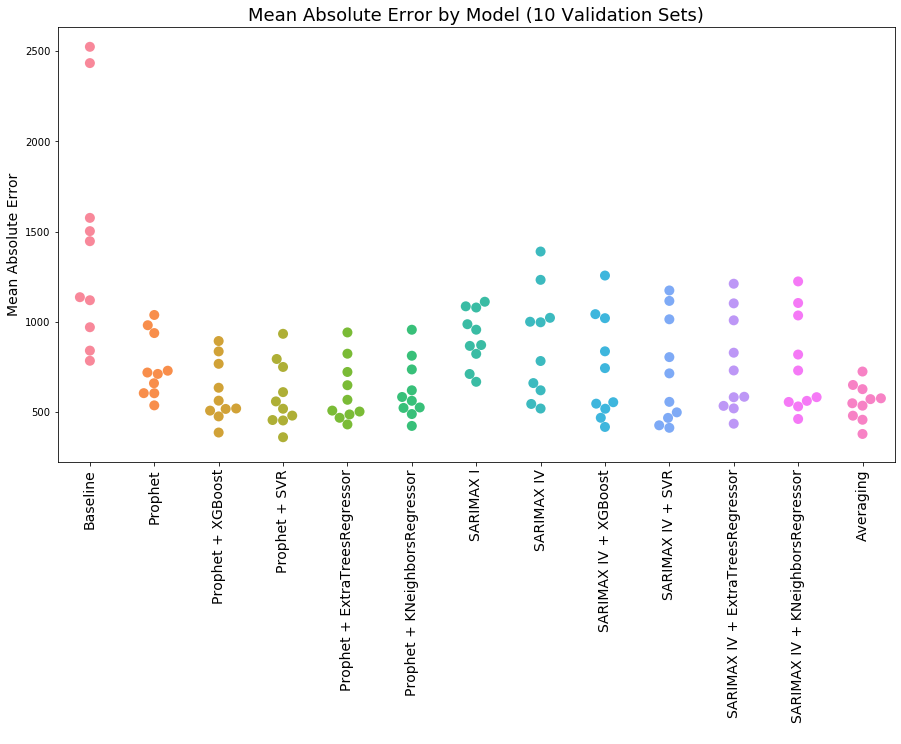

In [10]:
fig, ax = plt.subplots(figsize=(15,8))
sns.swarmplot(y = 'mae', x='model', data=mae_res, ax=ax, size=10)
plt.xticks(rotation=90,fontsize=14)
ax.set_title('Mean Absolute Error by Model (10 Validation Sets)', fontsize=18)
ax.set_ylabel('Mean Absolute Error', fontsize=14)
ax.set_xlabel(' ')
plt.savefig(PROJECT_DIR / 'notebooks' / 'saved-images' / 'model-performance-metrics-mae.PNG', bbox_inches='tight')
plt.show()

In [11]:
prec_res = results[[col for col in results.columns if 'mae' not in col]]
prec_res = prec_res.melt().rename(columns={'value': 'bound', 'variable': 'model'})
prec_res['model'] = prec_res['model'].str.replace(' bound', '')
prec_res.head()

,model,bound
0,Baseline,0.6
1,Baseline,0.8
2,Baseline,0.6
3,Baseline,0.4
4,Baseline,0.6


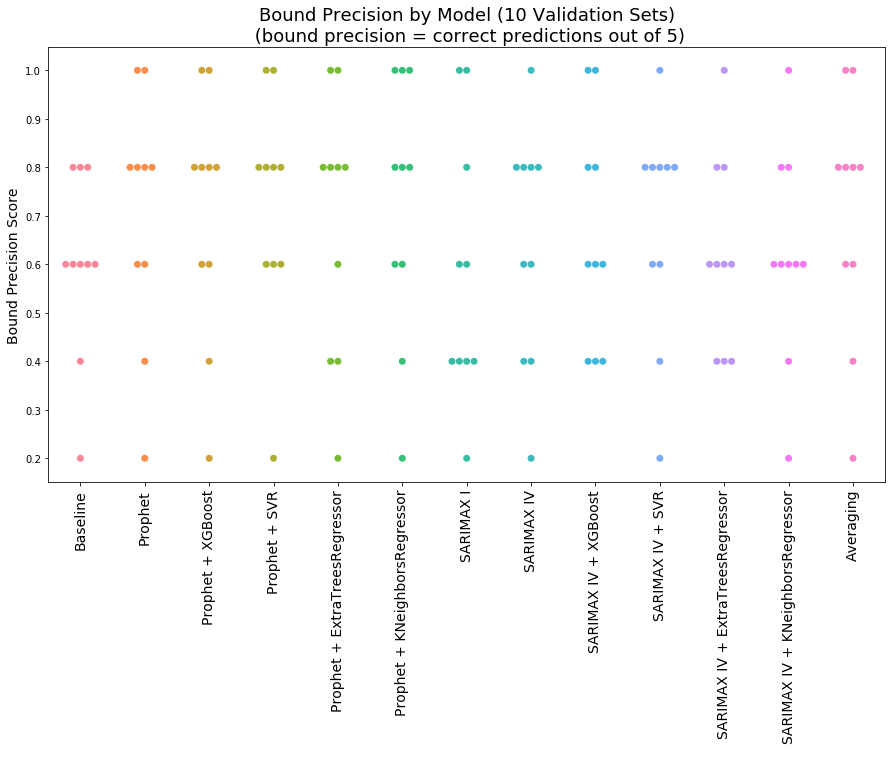

In [12]:
fig, ax = plt.subplots(figsize=(15,8))
#prec_res['model'] = prec_res['model'].str.replace('bound', '')
sns.swarmplot(y ='bound', x='model', data=prec_res, ax=ax, size=7)
plt.xticks(rotation=90,fontsize=14)
ax.set_ylabel('Bound Precision Score', fontsize=14)
ax.set_xlabel(' ')
plt.xticks(rotation=90)
ax.set_title('Bound Precision by Model (10 Validation Sets)\n (bound precision = correct predictions out of 5)', fontsize=18)
plt.savefig(PROJECT_DIR / 'notebooks' / 'saved-images' / 'model-performance-metrics-bound_precision.PNG', bbox_inches='tight')
plt.show()

By observation, it can be seen that for Prophet based models; Prophet + SVR is most heavily weighted at the high precisions

For the SARIMAX based models; SARIMAX IV + SVR is most heavily weighted at the high precisions

Therfore, these are the two models that I will use in averaging